In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PositionalNoiseEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, sigma):
        device = sigma.device # sigma is noise level

        half_dim = self.embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = sigma[:, None] * emb[None, :]  # (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # (B, embedding_dim)
        return emb

class UNetDDPMpp(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=128):
        super().__init__()
        # Time embedding
        self.time_embed = PositionalNoiseEmbedding(time_emb_dim)
        self.time_emb_proj1 = nn.Linear(time_emb_dim, out_channels)
        self.time_emb_proj2 = nn.Linear(time_emb_dim, out_channels)
        self.time_emb_proj3 = nn.Linear(time_emb_dim, out_channels * 2)
    
        #encoder
        self.encoder1 = self.convolution_block(in_channels, out_channels)
        self.encoder2 = self.convolution_block(out_channels, out_channels*2)

        # Bottleneck
        self.bottleneck = self.convolution_block(out_channels * 2, out_channels * 4)

        #decoder
        self.decoder2 = self.up_block(out_channels * 4, out_channels * 2)
        self.decoder1 = self.up_block(out_channels * 2, out_channels)

        # Final output
        self.last_conv = nn.Conv2d(out_channels, 1, kernel_size=1)

    def convolution_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            self.convolution_block(out_c * 2, out_c)
        )  
    
    def forward(self, x, sigma):
        # return x_pred  
        # # Predicted noise 
        # # maybe need time embedding
        t_emb = self.time_embed(sigma)  # [batch, time_emb_dim]

        # Inject time embedding into each stage
        emb1 = self.time_emb_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        emb2 = self.time_emb_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        emb3 = self.time_emb_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)

        print('x ', x.shape, emb1.shape)
        enc1 = self.encoder1(x + emb1)

        enc2 = self.encoder2(F.max_pool2d(enc1, 2) + emb2)
        
        b = self.bottleneck(F.max_pool2d(enc2, 2) + emb3)

        d2 = self.decoder2[0](b)
        d2 = self.decoder2[1](torch.cat([d2, enc2], dim=1))

        d1 = self.decoder1[0](d2)
        d1 = self.decoder1[1](torch.cat([d1, enc1], dim=1))

        return self.last_conv(d1)
    
    # def beta_schedule(self, x):
    #     pass

    # def get_sigma_schedule(T, sigma_min=0.01, sigma_max=1.0):
    #    return torch.linspace(sigma_max, sigma_min, T)
    
    # def training_step(model, x0, sigmas, criterion):
    #     # Sample a timestep
    #     T = sigmas.shape[0]
    #     batch_size = x0.size(0)
    #     t = torch.randint(0, T, (batch_size,), device=x0.device)
    #     sigma_t = sigmas[t].to(x0.device)  # [B]

    #     # Sample noise and create noisy input
    #     noise = torch.randn_like(x0)
    #     x_noisy = x0 + sigma_t[:, None, None, None] * noise  # [B, C, H, W]

    #     # Predict noise
    #     pred_noise = model(x_noisy, sigma_t)

    #     # VP Loss: MSE between true noise and predicted noise
    #     loss = criterion(pred_noise, noise)
    #     return loss
    
    # def get_precondition(self, sigma, M=1000): #based on table1 EDM
    #     sigma = sigma.view(-1, 1, 1, 1)  # Shape: [B, 1, 1, 1]
    #     c_skip = torch.ones_like(sigma) 
    #     c_out = -sigma
    #     c_in = 1/(torch.sqrt(sigma**2 + 1))

    #     c_noise = (M - 1) * sigma**(-1) # inverse sigma

    #     return c_skip, c_out, c_in, c_noise
    
    # def denoise(self, x, sigma, M=1000):

    #     c_skip, c_out, c_in, c_noise = self.get_precondition(sigma, M)

    #     # Reshape for broadcasting over image
    #     c_in = c_in.view(-1, 1, 1, 1)
    #     c_out = c_out.view(-1, 1, 1, 1)
    #     c_skip = c_skip.view(-1, 1, 1, 1)

    #     c_noise = c_noise.view(-1, 1, 1, 1)

    #     # Predict noise from preconditioned input
    #     x_in = c_in * x
    #     noise_cond = c_noise  # Pass to U-Net
    #     predicted_noise = self(x_in, noise_cond)

    #     # Recover denoised image
    #     x_denoised = c_skip * x + c_out * predicted_noise
    #     return x_denoised


#### test
model = UNetDDPMpp()
x = torch.randn(2, 3, 128, 128)  # batch_size=1, 1 channel, 128x128 image
sigma = torch.randn(x.shape[0])   # Random noise schedule for batch size 1

y = model(x, sigma)
print(y.shape)  # Output: torch.Size([1, 1, 128, 128])





x  torch.Size([2, 3, 128, 128]) torch.Size([2, 3, 1, 1])
torch.Size([2, 1, 128, 128])


In [ ]:
class Denoiser(nn.Module):
    def __init__(self, unet, M=1000):
        super().__init__()
        self.unet = unet
        self.M = M

    def get_precondition(self, sigma):
        sigma = sigma.view(-1, 1, 1, 1)  # Shape: [B, 1, 1, 1]
        c_skip = torch.ones_like(sigma) 
        c_out = -sigma
        c_in = 1 / (torch.sqrt(sigma**2 + 1))

        c_noise = (self.M - 1) * sigma**(-1)  # Inverse sigma
        return c_skip, c_out, c_in, c_noise

    def denoise(self, x, sigma):
        c_skip, c_out, c_in, c_noise = self.get_precondition(sigma)

        c_in = c_in.view(-1, 1, 1, 1)
        c_out = c_out.view(-1, 1, 1, 1)
        c_skip = c_skip.view(-1, 1, 1, 1)
        c_noise = c_noise.view(-1, 1, 1, 1)

        # t_emb = self.unet.time_embed(sigma)  # [B, time_emb_dim]

        x_in = c_in * x
        predicted_noise = self.unet(x_in, sigma)

        x_denoised = c_skip * x + c_out * predicted_noise
        return x_denoised

        


In [4]:
unet_model = UNetDDPMpp()
denoiser = Denoiser(unet_model)

#test
x = torch.randn(2, 3, 128, 128)  # Noisy input
sigma = torch.tensor([0.1, 0.5])  # batch of noise levels

# Denoise the image
denoised = denoiser.denoise(x, sigma)
print(denoised.shape)  # Should be [2, 1, 128, 128]


x  torch.Size([2, 3, 128, 128]) torch.Size([2, 3, 1, 1])
torch.Size([2, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.2711744..4.5148396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.999433..5.2846446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.874448..6.2095776].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.9597883..7.356836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.359748..8.836661].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.2575..10.842678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13.003144..13.7

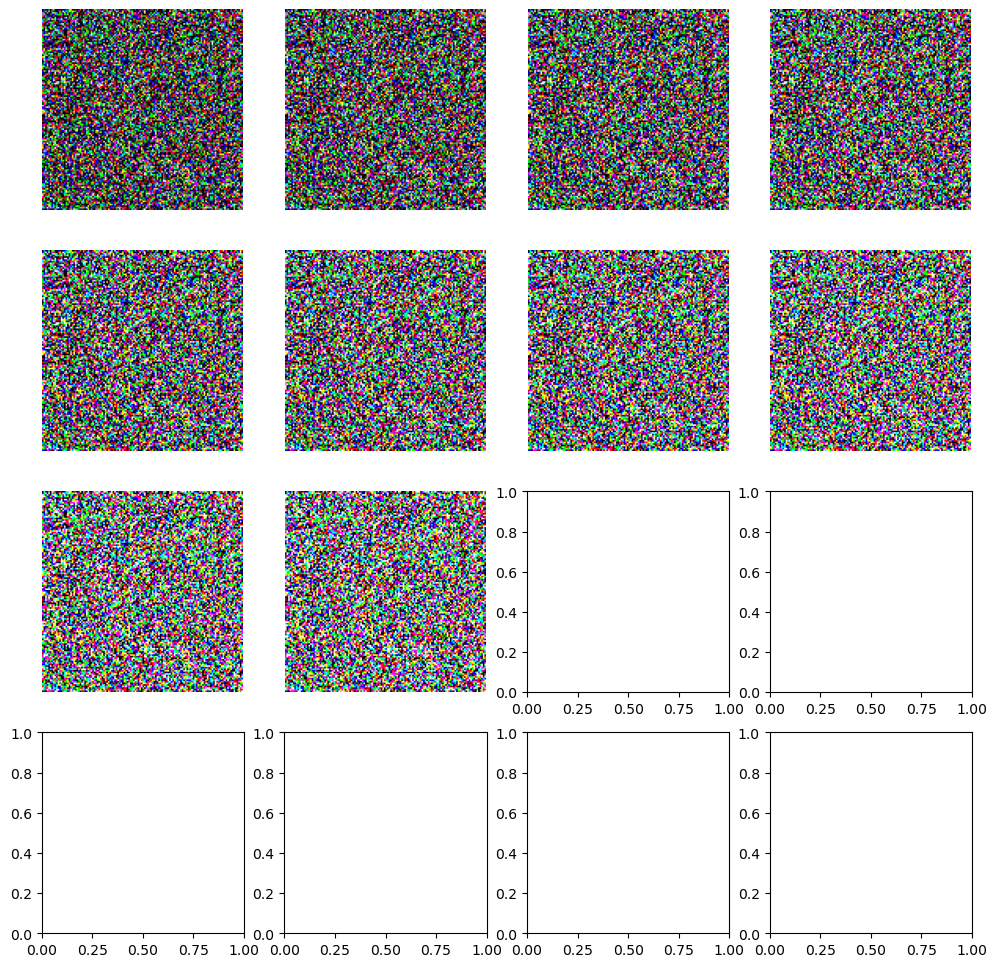

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
def linear_beta_schedule(timesteps, beta_min=0.0001, beta_max=0.02):
    return torch.linspace(beta_min, beta_max, timesteps)

def cosine_beta_schedule(timesteps):
    steps = torch.arange(timesteps)
    return 0.5 * (1 + torch.cos((steps / timesteps) * np.pi))

def forward_diffusion_process(x_0, beta_schedule, num_timesteps=1000):
    """
    x_0: The clean image (tensor)
    """
    x_t = x_0
    noise = torch.randn_like(x_0) 
    
   
    noisy_images = []  # images at each timestep
    
    for t in range(num_timesteps):
        # Add noise according to the beta schedule
        noise_factor = torch.sqrt(beta_schedule[t])
        x_t = torch.sqrt(1 - beta_schedule[t]) * x_t + noise_factor * noise
        noisy_images.append(x_t.clone())  # Store the noisy image for each timestep
        
    return noisy_images

def show_images(images, num_rows=4, num_cols=4, figsize=(12, 12)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].squeeze(0)  
            ax.imshow(img.permute(1, 2, 0).cpu().numpy())
            ax.axis('off')
    plt.show()

img_path = '../dog.jpg'
img = Image.open(img_path)
transform = transforms.Compose([transforms.Resize(128), transforms.CenterCrop(128), transforms.ToTensor()])
img_tensor = transform(img).unsqueeze(0) * 2 - 1  # Normalize to [-1, 1]

timesteps = 1000

# beta_schedule = linear_beta_schedule(timesteps)
beta_schedule = cosine_beta_schedule(timesteps)

noisy_images = forward_diffusion_process(img_tensor, beta_schedule, num_timesteps=timesteps)

show_images(noisy_images[::100], num_rows=4, num_cols=4)